FINAL PROJECT: BLEBLBLEBEL

Group bleble

Team members:

In [18]:
# Import necessary libraries:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, expected_returns, risk_models, plotting
from pypfopt.objective_functions import L2_reg
from pypfopt import EfficientFrontier, risk_models, expected_returns

Create a table including all data points

In [4]:
bond = pd.read_csv("data/bond_yield_daily.csv")
stock = pd.read_csv("data/stock_index_daily.csv")

print(bond.head())
print(stock.head())

         Ngày  Lần cuối     Mở    Cao   Thấp % Thay đổi
0  01/10/2025     3.761  3.761  3.761  3.761      0.00%
1  30/09/2025     3.761  3.761  3.761  3.761      0.00%
2  29/09/2025     3.761  3.759  3.761  3.759      0.05%
3  26/09/2025     3.759  3.759  3.759  3.759      0.24%
4  25/09/2025     3.750  3.750  3.750  3.750      1.16%
         Ngày  Lần cuối        Mở       Cao      Thấp       KL % Thay đổi
0  01/10/2025  1,665.05  1,661.70  1,671.07  1,655.85  666.00M      0.20%
1  30/09/2025  1,661.70  1,666.48  1,676.80  1,645.97    1.05B     -0.29%
2  29/09/2025  1,666.48  1,660.70  1,674.84  1,639.20  808.66M      0.35%
3  26/09/2025  1,660.70  1,666.09  1,671.43  1,652.65  899.32M     -0.32%
4  25/09/2025  1,666.09  1,657.46  1,668.21  1,654.47  914.94M      0.52%


In [5]:
# ------------ 1. READ CSV FILES ------------ #

# Bond & Stock have date format: "01/10/2025" (day/month/year)
bond = pd.read_csv("data/bond_yield_daily.csv")
stock = pd.read_csv("data/stock_index_daily.csv")


bond = bond.iloc[::-1].reset_index(drop=True)
stock = stock.iloc[::-1].reset_index(drop=True)

bond['date'] = pd.to_datetime(bond['Ngày'], format="%d/%m/%Y", errors='coerce')
stock['date'] = pd.to_datetime(stock['Ngày'], format="%d/%m/%Y", errors='coerce')

# print(bond.head())
# print(stock.head())
# Convert 'Lần cuối' to numeric for bond and stock data
bond['Lần cuối'] = pd.to_numeric(bond['Lần cuối'].astype(str).str.replace(',', '').str.strip(), errors='coerce')
stock['Lần cuối'] = pd.to_numeric(stock['Lần cuối'].astype(str).str.replace(',', '').str.strip(), errors='coerce')



# Gold has format: "2025-08-15" (year-month-day)
gold = pd.read_csv("data/gold_prices_daily.csv")
gold['date'] = pd.to_datetime(gold['date'], format="%Y-%m-%d")
# Remove currency symbol and thousand separators
gold['gold_price_vnd'] = (
    gold['gold_price_vnd']
    .astype(str)
    .str.replace('₫', '', regex=False)
    .str.replace(',', '', regex=False)   # REMOVE COMMAS
    .str.strip()                         # remove any extra spaces
)

# Convert to numeric
gold['gold_price_vnd'] = pd.to_numeric(gold['gold_price_vnd'], errors='coerce')


In [6]:
# ------------ 3. GROUP BY MONTH ------------ #

bond['month_year'] = bond['date'].dt.to_period("M")
stock['month_year'] = stock['date'].dt.to_period("M")
gold['month_year'] = gold['date'].dt.to_period("M")

bond_monthly = bond.groupby("month_year")['Lần cuối'].mean().reset_index()
stock_monthly = stock.groupby("month_year")['Lần cuối'].mean().reset_index()
gold_monthly = gold.groupby("month_year")['gold_price_vnd'].mean().reset_index()

bond_monthly = bond_monthly.rename(columns={"Lần cuối": "bond_yield"})
stock_monthly = stock_monthly.rename(columns={"Lần cuối": "stock_index"})

In [7]:
# ------------ 4. MERGE ------------ #

df = gold_monthly.merge(bond_monthly, on="month_year", how="outer") \
                 .merge(stock_monthly, on="month_year", how="outer")

df['month_year'] = df['month_year'].astype(str)

print(df)

    month_year  gold_price_vnd  bond_yield  stock_index
0      2015-10    2.584734e+07    7.034208   589.446818
1      2015-11    2.432134e+07    7.073727   602.326667
2      2015-12    2.405079e+07    7.059652   569.667826
3      2016-01    2.457863e+07    7.056091   548.304500
4      2016-02    2.682969e+07    7.007045   551.670000
..         ...             ...         ...          ...
116    2025-06    8.746790e+07    3.281429  1343.840476
117    2025-07    8.737124e+07    3.381652  1465.106957
118    2025-08    8.855705e+07    3.564571  1619.252381
119    2025-09    9.680589e+07    3.702182  1660.869500
120    2025-10    1.020920e+08    3.761000  1665.050000

[121 rows x 4 columns]


In [8]:

df_returns = df.copy()

# Compute log returns
df_returns['gold_log_return'] = np.log(df_returns['gold_price_vnd'] / df_returns['gold_price_vnd'].shift(1))
df_returns['bond_log_return'] = np.log(df_returns['bond_yield'] / df_returns['bond_yield'].shift(1))
df_returns['stock_log_return'] = np.log(df_returns['stock_index'] / df_returns['stock_index'].shift(1))

# Drop the first row (NaN from shift)
df_returns = df_returns.dropna().reset_index(drop=True)

print(df_returns.head())

  month_year  gold_price_vnd  bond_yield  stock_index  gold_log_return  \
0    2015-11    2.432134e+07    7.073727   602.326667        -0.060853   
1    2015-12    2.405079e+07    7.059652   569.667826        -0.011187   
2    2016-01    2.457863e+07    7.056091   548.304500         0.021710   
3    2016-02    2.682969e+07    7.007045   551.670000         0.087632   
4    2016-03    2.773421e+07    6.872565   572.673913         0.033158   

   bond_log_return  stock_log_return  
0         0.005602          0.021615  
1        -0.001992         -0.055747  
2        -0.000505         -0.038223  
3        -0.006975          0.006119  
4        -0.019379          0.037366  


In [9]:
# Select log return columns
returns = df_returns[['gold_log_return', 'bond_log_return', 'stock_log_return']]

# Annualize mean return vector
mean_return_annual = returns.mean() * 12

# Annualize covariance matrix
cov_matrix_annual = returns.cov() * 12

print("Annualized Mean Return Vector:")
print(mean_return_annual)

print("\nAnnualized Covariance Matrix:")
print(cov_matrix_annual)


Annualized Mean Return Vector:
gold_log_return     0.137367
bond_log_return    -0.062610
stock_log_return    0.103843
dtype: float64

Annualized Covariance Matrix:
                  gold_log_return  bond_log_return  stock_log_return
gold_log_return          0.012022         0.000820          0.000458
bond_log_return          0.000820         0.041907         -0.010131
stock_log_return         0.000458        -0.010131          0.027227


Case 1:

In [10]:
# mean return vector and covariance matrix from your data
mu = mean_return_annual.values        # array of expected returns
Sigma = cov_matrix_annual.values      # covariance matrix

# Number of assets
n = len(mu)

# Objective function: negative simplified Sharpe Ratio
def neg_sharpe(w, mu, Sigma):
    return - (w @ mu) / np.sqrt(w @ Sigma @ w)

# Constraints: sum of weights = 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bounds: long-only (0 <= w_i <= 1)
bounds = tuple((0, 1) for _ in range(n))

# Initial guess (equal weights)
w0 = np.array([1/n]*n)

# Optimize
result = minimize(neg_sharpe, w0, args=(mu, Sigma), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
w_opt = result.x
print("Optimal Weights:", w_opt)
print("Maximum Simplified Sharpe Ratio:", -result.fun)

Optimal Weights: [7.5719603e-01 1.7224816e-15 2.4280397e-01]
Maximum Simplified Sharpe Ratio: 1.388146653581787


Case 2:


In [11]:
# mean return vector and covariance matrix from your data
mu = mean_return_annual.values        # array of expected returns
Sigma = cov_matrix_annual.values      # covariance matrix

# Number of assets
n = len(mu)

# Identify index for Gold and Bond
# Assuming order: [Gold, Bond, Stock]
idx_gold = 0
idx_bond = 1

# Objective function: negative simplified Sharpe Ratio
def neg_sharpe(w, mu, Sigma):
    return - (w @ mu) / np.sqrt(w @ Sigma @ w)

# Constraints:

# 1. Full investment
cons = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

# Bounds for each asset
# Long-only: 0 <= w_i <= 1
bounds = [(0,1) for _ in range(n)]

# 2. Gold minimum 5%
bounds[idx_gold] = (0.05, 1)

# 3. Bond maximum 30%
bounds[idx_bond] = (0, 0.30)

# Initial guess (equal weights within bounds)
w0 = np.array([0.33, 0.33, 0.34])
w0[idx_gold] = max(w0[idx_gold], 0.05)
w0[idx_bond] = min(w0[idx_bond], 0.30)
w0 = w0 / np.sum(w0)  # normalize to sum to 1

# Optimize
result = minimize(neg_sharpe, w0, args=(mu, Sigma), method='SLSQP', bounds=bounds, constraints=cons)

# Optimal weights
w_opt = result.x
print("Optimal Weights (Case 2):", w_opt)
print("Maximum Simplified Sharpe Ratio (Case 2):", -result.fun)

Optimal Weights (Case 2): [7.56725661e-01 2.36842235e-18 2.43274339e-01]
Maximum Simplified Sharpe Ratio (Case 2): 1.3881466107738607


Expected annual return: 8.5%
Annual volatility: 7.9%
Sharpe Ratio: 0.83
Expected annual return: 13.0%
Annual volatility: 9.4%
Sharpe Ratio: 0.96
Expected annual return: 8.5%
Annual volatility: 7.9%
Sharpe Ratio: 0.83
Expected annual return: 13.0%
Annual volatility: 9.4%
Sharpe Ratio: 0.96


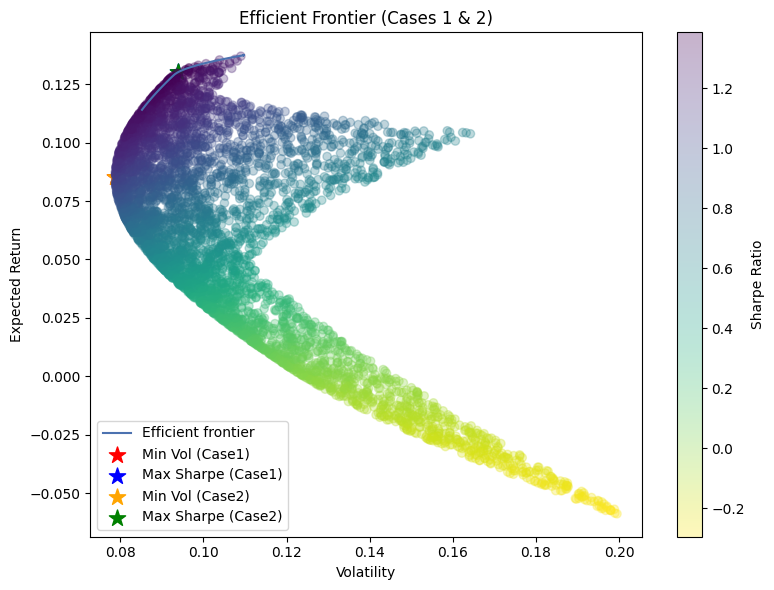

In [14]:


# mu = mean returns vector (annualized)
# S = covariance matrix (annualized)

# ---------------- CASE 1: Baseline ----------------
ef_case1 = EfficientFrontier(mu, Sigma)  # no extra constraints besides default bounds (0,1)

# Minimum volatility
ef_min_vol_case1 = ef_case1.deepcopy()
weights_min_vol_case1 = ef_min_vol_case1.min_volatility()
ret_min_vol, std_min_vol, _ = ef_min_vol_case1.portfolio_performance(verbose=True)

# Maximum Sharpe ratio
ef_max_sharpe_case1 = ef_case1.deepcopy()
weights_max_sharpe_case1 = ef_max_sharpe_case1.max_sharpe(risk_free_rate=0.04)
ret_max_sharpe, std_max_sharpe, _ = ef_max_sharpe_case1.portfolio_performance(verbose=True)

# ---------------- CASE 2: Gold floor & Bond cap ----------------
ef_case2 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))

# Add constraints
ef_case2.add_constraint(lambda w: w[0] >= 0.05)  # Gold >= 5%
ef_case2.add_constraint(lambda w: w[1] <= 0.30)  # Bond <= 30%
# Full investment and long-only are already handled by EfficientFrontier defaults

# Minimum volatility
ef_min_vol_case2 = ef_case2.deepcopy()
weights_min_vol_case2 = ef_min_vol_case2.min_volatility()
ret_min_vol2, std_min_vol2, _ = ef_min_vol_case2.portfolio_performance(verbose=True)

# Maximum Sharpe ratio
ef_max_sharpe_case2 = ef_case2.deepcopy()
weights_max_sharpe_case2 = ef_max_sharpe_case2.max_sharpe(risk_free_rate=0.04)
ret_max_sharpe2, std_max_sharpe2, _ = ef_max_sharpe_case2.portfolio_performance(verbose=True)

# ---------------- PLOT ----------------
fig, ax = plt.subplots(figsize=(8,6))

# Efficient frontier (baseline)
plotting.plot_efficient_frontier(ef_case1, ax=ax, show_assets=False, ef_param="risk")

# Highlight portfolios
ax.scatter(std_min_vol, ret_min_vol, marker="*", s=150, c="red", label="Min Vol (Case1)")
ax.scatter(std_max_sharpe, ret_max_sharpe, marker="*", s=150, c="blue", label="Max Sharpe (Case1)")
ax.scatter(std_min_vol2, ret_min_vol2, marker="*", s=150, c="orange", label="Min Vol (Case2)")
ax.scatter(std_max_sharpe2, ret_max_sharpe2, marker="*", s=150, c="green", label="Max Sharpe (Case2)")

# Random portfolios for scatter
n_samples = 5000
w_random = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets_random = w_random.dot(mu)
stds_random = np.sqrt(np.einsum('ij,jk,ik->i', w_random, Sigma, w_random))
sharpes_random = rets_random / stds_random
sc = ax.scatter(stds_random, rets_random, c=sharpes_random, cmap="viridis_r", alpha=0.3)

cbar = plt.colorbar(sc)
cbar.set_label("Sharpe Ratio")
ax.set_xlabel("Volatility")
ax.set_ylabel("Expected Return")
ax.set_title("Efficient Frontier (Cases 1 & 2)")
ax.legend()
plt.tight_layout()
plt.show()

Expected annual return: 8.5%
Annual volatility: 7.9%
Sharpe Ratio: 0.83
Expected annual return: 13.0%
Annual volatility: 9.4%
Sharpe Ratio: 0.96


c:\Users\hehe\AppData\Local\Programs\Python\Python38\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


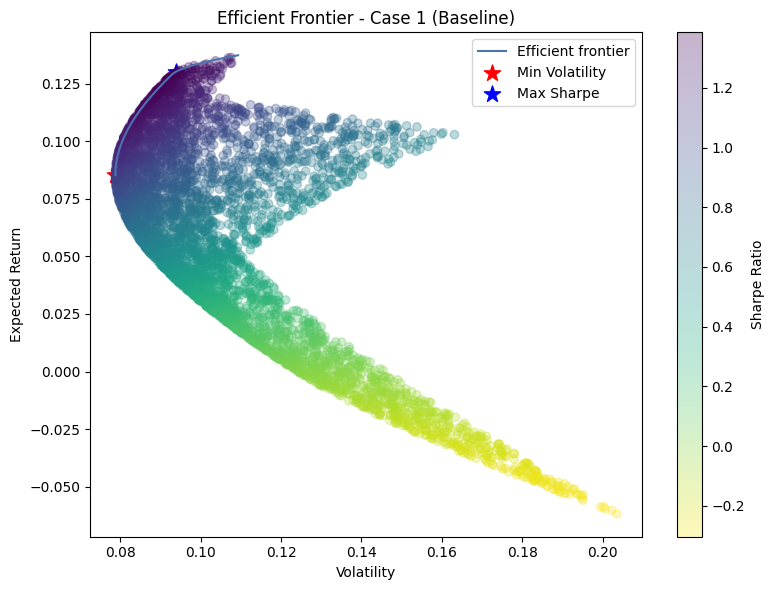

In [15]:

# ---------------- CASE 1: Baseline ----------------
ef_case1 = EfficientFrontier(mu, Sigma)  # Full investment + long-only

# Minimum volatility
ef_min_vol_case1 = ef_case1.deepcopy()
weights_min_vol_case1 = ef_min_vol_case1.min_volatility()
ret_min_vol1, std_min_vol1, _ = ef_min_vol_case1.portfolio_performance(verbose=True)

# Maximum Sharpe ratio
ef_max_sharpe_case1 = ef_case1.deepcopy()
weights_max_sharpe_case1 = ef_max_sharpe_case1.max_sharpe(risk_free_rate=0.04)
ret_max_sharpe1, std_max_sharpe1, _ = ef_max_sharpe_case1.portfolio_performance(verbose=True)

# ---------------- PLOT CASE 1 ----------------
fig1, ax1 = plt.subplots(figsize=(8,6))
plotting.plot_efficient_frontier(ef_case1, ax=ax1, show_assets=False)

# Highlight portfolios
ax1.scatter(std_min_vol1, ret_min_vol1, marker="*", s=150, c="red", label="Min Volatility")
ax1.scatter(std_max_sharpe1, ret_max_sharpe1, marker="*", s=150, c="blue", label="Max Sharpe")

# Random portfolios
n_samples = 5000
w_random = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets_random = w_random.dot(mu)
stds_random = np.sqrt(np.einsum('ij,jk,ik->i', w_random, Sigma, w_random))
sharpes_random = rets_random / stds_random
sc = ax1.scatter(stds_random, rets_random, c=sharpes_random, cmap="viridis_r", alpha=0.3)

cbar = plt.colorbar(sc, ax=ax1)
cbar.set_label("Sharpe Ratio")
ax1.set_xlabel("Volatility")
ax1.set_ylabel("Expected Return")
ax1.set_title("Efficient Frontier - Case 1 (Baseline)")
ax1.legend()
plt.tight_layout()
plt.show()

Expected annual return: 8.5%
Annual volatility: 7.9%
Sharpe Ratio: 0.83
Expected annual return: 13.0%
Annual volatility: 9.4%
Sharpe Ratio: 0.96


c:\Users\hehe\AppData\Local\Programs\Python\Python38\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


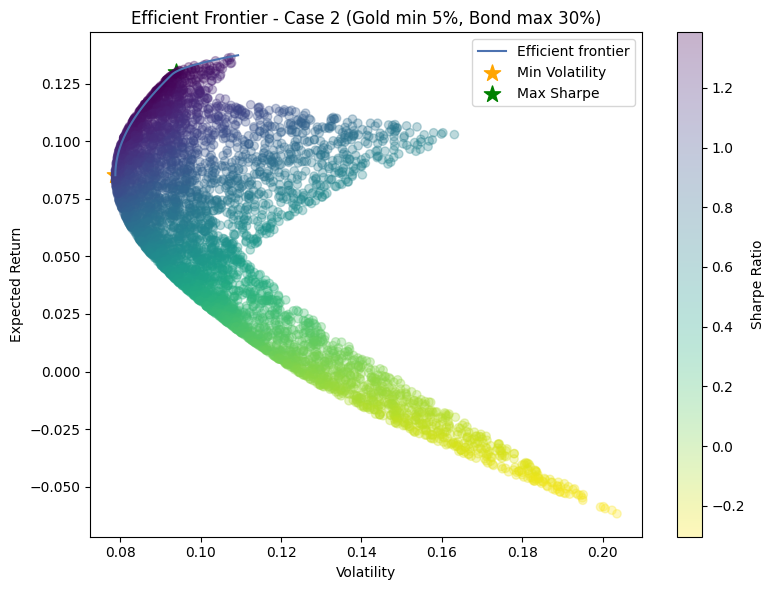

In [17]:

# ---------------- CASE 2: Gold min & Bond max ----------------
ef_case2 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))
ef_case2.add_constraint(lambda w: w[0] >= 0.05)  # Gold >= 5%
ef_case2.add_constraint(lambda w: w[1] <= 0.30)  # Bond <= 30%

# Minimum volatility
ef_min_vol_case2 = ef_case2.deepcopy()
weights_min_vol_case2 = ef_min_vol_case2.min_volatility()
ret_min_vol2, std_min_vol2, _ = ef_min_vol_case2.portfolio_performance(verbose=True)

# Maximum Sharpe ratio
ef_max_sharpe_case2 = ef_case2.deepcopy()
weights_max_sharpe_case2 = ef_max_sharpe_case2.max_sharpe(risk_free_rate=0.04)
ret_max_sharpe2, std_max_sharpe2, _ = ef_max_sharpe_case2.portfolio_performance(verbose=True)

# ---------------- PLOT CASE 2 ----------------
fig2, ax2 = plt.subplots(figsize=(8,6))
plotting.plot_efficient_frontier(ef_case2, ax=ax2, show_assets=False)

# Highlight portfolios
ax2.scatter(std_min_vol2, ret_min_vol2, marker="*", s=150, c="orange", label="Min Volatility")
ax2.scatter(std_max_sharpe2, ret_max_sharpe2, marker="*", s=150, c="green", label="Max Sharpe")

# Random portfolios
sc2 = ax2.scatter(stds_random, rets_random, c=sharpes_random, cmap="viridis_r", alpha=0.3)
cbar2 = plt.colorbar(sc2, ax=ax2)
cbar2.set_label("Sharpe Ratio")
ax2.set_xlabel("Volatility")
ax2.set_ylabel("Expected Return")
ax2.set_title("Efficient Frontier - Case 2 (Gold min 5%, Bond max 30%)")
ax2.legend()
plt.tight_layout()
plt.show()

Question 3:

In [26]:
print(df.columns)


Index(['gold_price_vnd', 'bond_yield', 'stock_index'], dtype='object')


In [27]:
log_returns = np.log(df / df.shift(1)).dropna()

# 3. Check types
print(log_returns.dtypes)  # should all be float

# 4. Annualized mean return vector and covariance matrix
mu = log_returns.mean() * 12
S = log_returns.cov() * 12

print(mu)
print(S)

gold_price_vnd    float64
bond_yield        float64
stock_index       float64
dtype: object
gold_price_vnd    0.137367
bond_yield       -0.062610
stock_index       0.103843
dtype: float64
                gold_price_vnd  bond_yield  stock_index
gold_price_vnd        0.012022    0.000820     0.000458
bond_yield            0.000820    0.041907    -0.010131
stock_index           0.000458   -0.010131     0.027227


In [28]:


risk_free_rate = 0.04

# ---------- CASE 1: No weight constraints ----------
ef_case1 = EfficientFrontier(mu, S)  # only full investment + long-only by default
weights_case1 = ef_case1.max_sharpe(risk_free_rate=risk_free_rate)
cleaned_case1 = ef_case1.clean_weights()
print("Case 1 - Optimal Weights (no constraints):")
print(cleaned_case1)
ef_case1.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)

# ---------- CASE 2: Gold min & Bond max ----------
ef_case2 = EfficientFrontier(mu, S, weight_bounds=(0,1))
ef_case2.add_constraint(lambda w: w[0] >= 0.05)  # Gold min 5%
ef_case2.add_constraint(lambda w: w[1] <= 0.30)  # Bond max 30%
weights_case2 = ef_case2.max_sharpe(risk_free_rate=risk_free_rate)
cleaned_case2 = ef_case2.clean_weights()
print("\nCase 2 - Optimal Weights (Gold min 5%, Bond max 30%):")
print(cleaned_case2)
ef_case2.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)

Case 1 - Optimal Weights (no constraints):
OrderedDict([('gold_price_vnd', 0.78386), ('bond_yield', 0.0), ('stock_index', 0.21614)])
Expected annual return: 13.0%
Annual volatility: 9.4%
Sharpe Ratio: 0.96

Case 2 - Optimal Weights (Gold min 5%, Bond max 30%):
OrderedDict([('gold_price_vnd', 0.78386), ('bond_yield', 0.0), ('stock_index', 0.21614)])
Expected annual return: 13.0%
Annual volatility: 9.4%
Sharpe Ratio: 0.96


(0.13012082952496484, 0.09388251746263765, 0.9599319656168163)

In [33]:
df_returns.index = pd.to_datetime(df_returns.index, format='%Y-%m')  # if format is 'YYYY-MM'
df_returns = df_returns.sort_index()  # ensure ascending order

df_returns = df_returns.apply(pd.to_numeric, errors='coerce')  # convert any object/str columns to float
df_returns = df_returns.dropna(axis=1, how='all')  # drop columns that are completely non-numeric

print(df_returns.dtypes)  # should all be float64

gold_price_vnd      float64
bond_yield          float64
stock_index         float64
gold_log_return     float64
bond_log_return     float64
stock_log_return    float64
dtype: object


In [37]:
# ------------------- Preprocessing -------------------
# Ensure index is datetime
df_returns.index = pd.to_datetime(df_returns.index, format='%Y-%m')
df_returns = df_returns.sort_index()

# Convert all columns to numeric and drop fully non-numeric
df_returns = df_returns.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')

# Compute log returns
log_returns = np.log(df_returns / df_returns.shift(1)).dropna()

# ------------------- Rolling Optimal Weights -------------------
risk_free_rate = 0.04  # 4% annual VN risk-free rate

months = df_returns.index.to_period('M')
weights_case1 = []
weights_case2 = []
weights_index = []

for i in range(2, len(df_returns)):  # start from 2 months to have cov calculation
    returns_up_to_month = df_returns.iloc[:i].dropna(axis=1, how='any')  # drop columns with NaN

    # Skip if fewer than 2 assets
    if returns_up_to_month.shape[1] < 2:
        continue

    # Annualized mean and covariance
    mu = returns_up_to_month.mean() * 12
    S = returns_up_to_month.cov() * 12

    # Ensure covariance is symmetric
    S = (S + S.T) / 2
    S += np.eye(S.shape[0]) * 1e-8  # tiny stabilization

    # ---------- Case 1: No allocation constraints ----------
    ef1 = EfficientFrontier(mu, S)
    ef1.max_sharpe(risk_free_rate=risk_free_rate)
    weights_case1.append(ef1.clean_weights())

    # ---------- Case 2: Gold min 5%, Bond max 30% ----------
    ef2 = EfficientFrontier(mu, S, weight_bounds=(0,1))
    ef2.add_constraint(lambda w: w[0] >= 0.05)  # Gold min 5%
    ef2.add_constraint(lambda w: w[1] <= 0.30)  # Bond max 30%
    ef2.max_sharpe(risk_free_rate=risk_free_rate)
    weights_case2.append(ef2.clean_weights())

    # Store month label
    weights_index.append(months[i])

# ------------------- Convert to DataFrame -------------------
weights_df_case1 = pd.DataFrame(weights_case1, index=weights_index)
weights_df_case2 = pd.DataFrame(weights_case2, index=weights_index)

# ------------------- Plotting -------------------
# Case 1
weights_df_case1.plot(kind='bar', stacked=True, figsize=(14,6), width=1, colormap='tab20')
plt.title("Rolling Portfolio Allocation Over Time - Case 1 (No Constraints)")
plt.xlabel("Month")
plt.ylabel("Weight")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Case 2
weights_df_case2.plot(kind='bar', stacked=True, figsize=(14,6), width=1, colormap='tab20')
plt.title("Rolling Portfolio Allocation Over Time - Case 2 (Gold min 5%, Bond max 30%)")
plt.xlabel("Month")
plt.ylabel("Weight")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


c:\Users\hehe\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


OptimizationError: Please check your objectives/constraints or use a different solver.